# Stimuli using Bézier Curves

In [25]:
%matplotlib inline

import sys
import os

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

from pathlib import Path

import numpy as np
import scipy
from scipy.spatial import cKDTree

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

if "pygestalt" in sys.modules:
    del sys.modules["pygestalt"]

import pygestalt as gs
from pygestalt import sampler

import skimage as ski

In [17]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

## Construction of a Bézier curve

We construct a Bézier curve by specifying a sequence of control points, with the first and the last one corresponding to the starting and the ending position of the curve.

#### A random Bezier curve

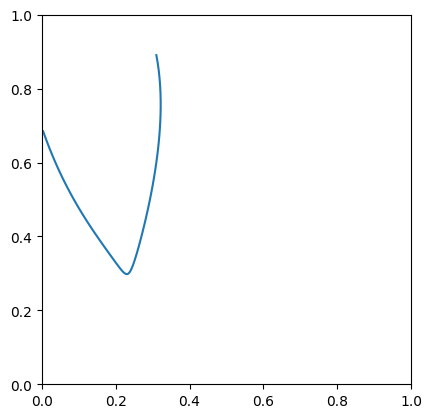

In [26]:
Ps = np.random.uniform(size=(6,2))
# Ps = np.vstack([[0.2,0], Ps, [0.8,1]])
bx, by = gs.sampler.bezier_curve_position(np.linspace(0,1,100),Ps).T

plt.plot(bx,by)
ax = plt.gca()
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect('equal')

### A fixed Bezier curve

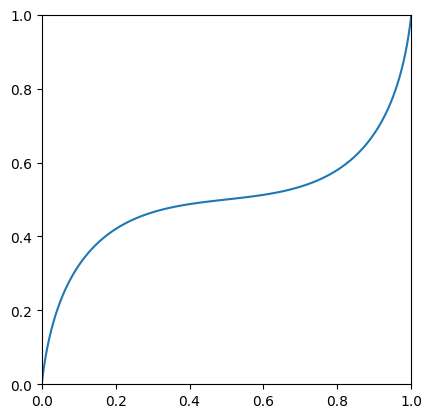

In [27]:
# Ps = np.random.uniform(size=(4,2))
# Ps = np.vstack([[0.2,0], Ps, [0.8,1]])

Ps = np.array([[0.,0.], [0.1,0.9], [0.9,0.1], [1.,1.]])
bx, by = gs.sampler.bezier_curve_position(np.linspace(0,1,100),Ps).T

plt.plot(bx,by)
ax = plt.gca()
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect('equal')

## Generate random stimuli using Bezier curves

In [28]:
radius = 0.02
thresh = 1e-3

%time C, H = sampler.draw_positions(radius, sampler.bezier_curve(Ps), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 3.5 s, sys: 28 ms, total: 3.52 s
Wall time: 3.54 s
CPU times: user 17.5 s, sys: 80.1 ms, total: 17.6 s
Wall time: 17.6 s


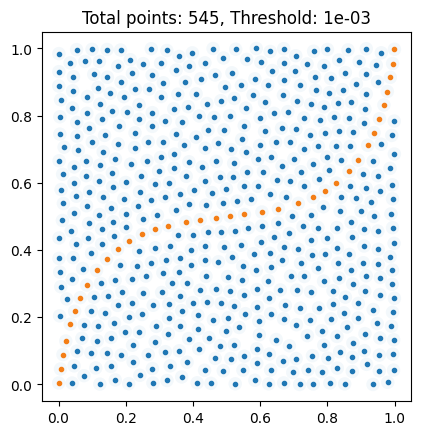

In [21]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

### Perfectly aligned segments

In [22]:
# Define the patch function

l=0.025
w=0.005
pfunc = lambda z,h: gs.patch.segment(z, h, l, w)

In [23]:
N = 512
If = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')

AttributeError: 'tuple' object has no attribute 'copy'

In [ ]:
import math
import numpy as np

def _sigma_prefactor(bandwidth):
    b = bandwidth
    # See http://www.cs.rug.nl/~imaging/simplecell.html
    return 1.0 / np.pi * math.sqrt(math.log(2) / 2.0) * (2.0**b + 1) / (2.0**b - 1)

def gabor_kernel(
    frequency,
    theta=0,
    bandwidth=1,
    sigma_x=None,
    sigma_y=None,
    n_stds=3,
    offset=0,
    dtype=np.complex128,
):
    """Return complex 2D Gabor filter kernel.

    Gabor kernel is a Gaussian kernel modulated by a complex harmonic function.
    Harmonic function consists of an imaginary sine function and a real
    cosine function. Spatial frequency is inversely proportional to the
    wavelength of the harmonic and to the standard deviation of a Gaussian
    kernel. The bandwidth is also inversely proportional to the standard
    deviation.

    Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    bandwidth : float, optional
        The bandwidth captured by the filter. For fixed bandwidth, ``sigma_x``
        and ``sigma_y`` will decrease with increasing frequency. This value is
        ignored if ``sigma_x`` and ``sigma_y`` are set by the user.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that ``sigma_x`` controls the *vertical*
        direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations
    offset : float, optional
        Phase offset of harmonic function in radians.
    dtype : {np.complex64, np.complex128}
        Specifies if the filter is single or double precision complex.

    Returns
    -------
    g : complex array
        Complex filter kernel.

    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Gabor_filter
    .. [2] https://web.archive.org/web/20180127125930/http://mplab.ucsd.edu/tutorials/gabor.pdf

    Examples
    --------
    >>> from skimage.filters import gabor_kernel
    >>> from matplotlib import pyplot as plt  # doctest: +SKIP

    >>> gk = gabor_kernel(frequency=0.2)
    >>> fig, ax = plt.subplots()  # doctest: +SKIP
    >>> ax.imshow(gk.real)        # doctest: +SKIP
    >>> plt.show()                # doctest: +SKIP

    >>> # more ripples (equivalent to increasing the size of the
    >>> # Gaussian spread)
    >>> gk = gabor_kernel(frequency=0.2, bandwidth=0.1)
    >>> fig, ax = plt.suplots()  # doctest: +SKIP
    >>> ax.imshow(gk.real)       # doctest: +SKIP
    >>> plt.show()               # doctest: +SKIP
    """
    if sigma_x is None:
        sigma_x = _sigma_prefactor(bandwidth) / frequency
    if sigma_y is None:
        sigma_y = _sigma_prefactor(bandwidth) / frequency

    if np.dtype(dtype).kind != 'c':
        raise ValueError("dtype must be complex")

    ct = math.cos(theta)
    st = math.sin(theta)
    x0 = math.ceil(max(abs(n_stds * sigma_x * ct), abs(n_stds * sigma_y * st), 1))
    y0 = math.ceil(max(abs(n_stds * sigma_y * ct), abs(n_stds * sigma_x * st), 1))
    y, x = np.meshgrid(
        np.arange(-y0, y0 + 1), np.arange(-x0, x0 + 1), indexing='ij', sparse=True
    )
    rotx = x * ct + y * st
    roty = -x * st + y * ct

    g = np.empty(roty.shape, dtype=dtype)
    np.exp(
        -0.5 * (rotx**2 / sigma_x**2 + roty**2 / sigma_y**2)
        + 1j * (2 * np.pi * frequency * rotx + offset),
        out=g,
    )
    g *= 1 / (2 * np.pi * sigma_x * sigma_y)

    return g


frequency = 0.1
theta = 0 #np.pi/4 # 90 degrees
bandwidth=1
sigma_x= 1.0 #None,
sigma_y= 3.0 #None,
n_stds=3.0
offset=0
mode='reflect'
cval=0
kernel_dtype = np.complex128

g = gabor_kernel(
    frequency,
    theta,
    bandwidth,
    sigma_x,
    sigma_y,
    n_stds,
    offset,
    dtype=kernel_dtype,
)

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

def show_gabor_kernel(g, cmap='gray'):
    """
    Display a complex Gabor kernel with real, imaginary, and magnitude.

    Parameters
    ----------
    g : np.ndarray
        Complex Gabor kernel.
    cmap : str
        Colormap for visualization.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(g.real, cmap=cmap, origin='lower')
    axes[0].set_title("Real Part")
    axes[0].axis('off')

    axes[1].imshow(g.imag, cmap=cmap, origin='lower')
    axes[1].set_title("Imaginary Part")
    axes[1].axis('off')

    axes[2].imshow(np.abs(g), cmap=cmap, origin='lower')
    axes[2].set_title("Magnitude")
    axes[2].axis('off')

    plt.suptitle("Gabor Kernel Visualization", fontsize=16)
    plt.tight_layout()
    plt.show()

# Usage

def interactive_gabor(frequency=0.1, theta=0.0, sigma_x=1.0, sigma_y=3.0):
    g = gabor_kernel(frequency, theta, sigma_x=sigma_x, sigma_y=sigma_y)
    show_gabor_kernel(g)

# Create sliders
freq_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, step=0.01, description='Frequency')
theta_slider = widgets.FloatSlider(value=0.0, min=0, max=np.pi, step=0.1, description='Theta')
sigmax_slider = widgets.FloatSlider(value=1.0, min=0.5, max=5.0, step=0.1, description='Sigma X')
sigmay_slider = widgets.FloatSlider(value=3.0, min=0.5, max=5.0, step=0.1, description='Sigma Y')

widgets.interactive(interactive_gabor,
                    frequency=freq_slider,
                    theta=theta_slider,
                    sigma_x=sigmax_slider,
                    sigma_y=sigmay_slider)

    # Embed kernel into 512x512 image



interactive(children=(FloatSlider(value=0.1, description='Frequency', max=0.5, min=0.01, step=0.01), FloatSlid…

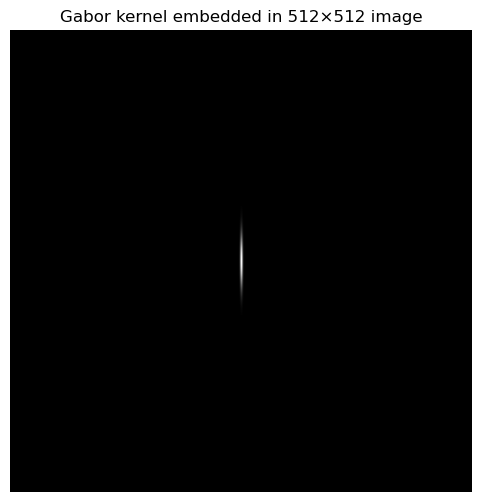

In [ ]:
img_size = 512
g = gabor_kernel(frequency, 0, sigma_x=sigma_x, sigma_y=20)
kernel_h, kernel_w = g.shape
img = np.zeros((img_size, img_size), dtype=float)

# Compute top-left corner to center the kernel
start_y = img_size // 2 - kernel_h // 2
start_x = img_size // 2 - kernel_w // 2

img[start_y:start_y + kernel_h, start_x:start_x + kernel_w] = np.abs(g)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray', origin='lower')
plt.title(f'Gabor kernel embedded in {img_size}×{img_size} image')
plt.axis('off')
plt.show()

Kernel width: 7.0 px (1.37% of image)
Kernel height: 19.0 px (3.71% of image)
Kernel width: 7.0 px (1.37% of image)
Kernel height: 19.0 px (3.71% of image)
Kernel width: 7.0 px (1.37% of image)
Kernel height: 19.0 px (3.71% of image)
Kernel width: 7.0 px (1.37% of image)
Kernel height: 19.0 px (3.71% of image)
Kernel width: 7.0 px (1.37% of image)
Kernel height: 19.0 px (3.71% of image)
Kernel width: 7.0 px (1.37% of image)
Kernel height: 19.0 px (3.71% of image)
Kernel width: 7.0 px (1.37% of image)
Kernel height: 19.0 px (3.71% of image)
Kernel width: 7.0 px (1.37% of image)
Kernel height: 19.0 px (3.71% of image)


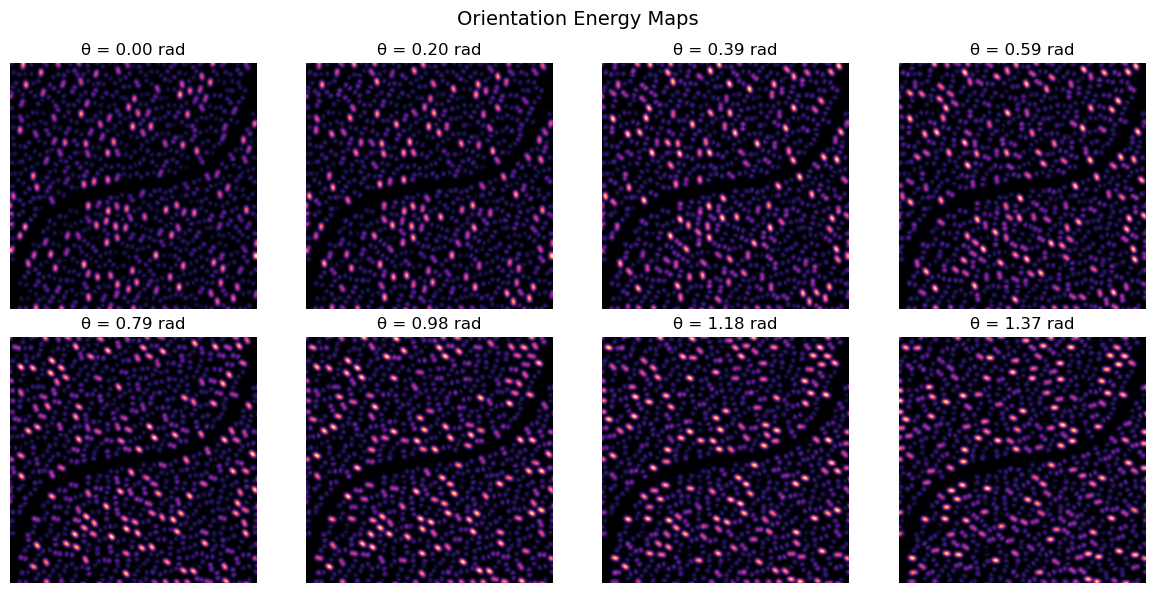

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gabor
from skimage import exposure


def compute_orientation_energy(If, orientations=None, frequency=0.1):
    """
    Compute orientation energy maps using Gabor filters.

    Parameters
    ----------
    If : np.ndarray
        2D grayscale image.
    orientations : list or np.ndarray
        List of orientations (radians) for Gabor filters.
    frequency : float
        Gabor filter frequency (default=0.1).

    Returns
    -------
    energy_maps : np.ndarray
        3D array of shape (H, W, num_orientations)
    orientations : np.ndarray
        Array of orientation angles used.
    """
    if orientations is None:
        orientations = np.linspace(0, np.pi/2, 8, endpoint=False)

    energy_maps = []
    for theta in orientations:
        real, imag = gabor(If, frequency=frequency, theta=theta) #, sigma_x=1, sigma_y=6)
        
        
        kernel_width = 2 * n_stds * sigma_x + 1
        kernel_height = 2 * n_stds * sigma_y + 1

        width_fraction  = kernel_width / 512
        height_fraction = kernel_height / 512

        print(f"Kernel width: {kernel_width} px ({width_fraction:.2%} of image)")
        print(f"Kernel height: {kernel_height} px ({height_fraction:.2%} of image)")
        energy = np.sqrt(real**2 + imag**2)
        energy_maps.append(energy)

    return np.stack(energy_maps, axis=-1), orientations


def plot_orientation_energy_maps(energy_maps, orientations, cmap="magma"):
    """
    Plot orientation energy maps.

    Parameters
    ----------
    energy_maps : np.ndarray
        3D array of shape (H, W, num_orientations)
    orientations : np.ndarray
        Array of orientation angles (radians)
    cmap : str
        Colormap for visualization.
    """
    n = len(orientations)
    fig, axes = plt.subplots(2, n // 2, figsize=(12, 6))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        energy_img = exposure.rescale_intensity(energy_maps[..., i])
        energy_img = np.fliplr(energy_img)
        ax.imshow(energy_img, cmap=cmap)
        ax.set_title(f"θ = {orientations[i]:.2f} rad")
        ax.axis("off")

    plt.suptitle("Orientation Energy Maps", fontsize=14)
    plt.tight_layout()
    plt.show()

# Normalize the image
If = Ig.astype(float)
If = (If - If.min()) / (If.max() - If.min() + 1e-8)

energy_maps, orientations = compute_orientation_energy(If, frequency=0.15)
plot_orientation_energy_maps(energy_maps, orientations)

In [ ]:
	# 1.	orientation_weight — computes a weight for each orientation pair:
	# •	Peaks at 0° → suppress co-linear energy.
	# •	Peaks at 90° → optional orthogonal modulation.
	# •	Intermediate angles → minimal contribution.
	# 2.	tensordot(E, W) — combines orientation contributions per pixel.
	# 3.	gaussian_filter — smooths across neighboring pixels to model spatial surround.
	# 4.	Division → normalized energy per orientation and location: R(x,y,θ).

In [ ]:
# minimise energy feature map by changing orientation randomly (jitter),  

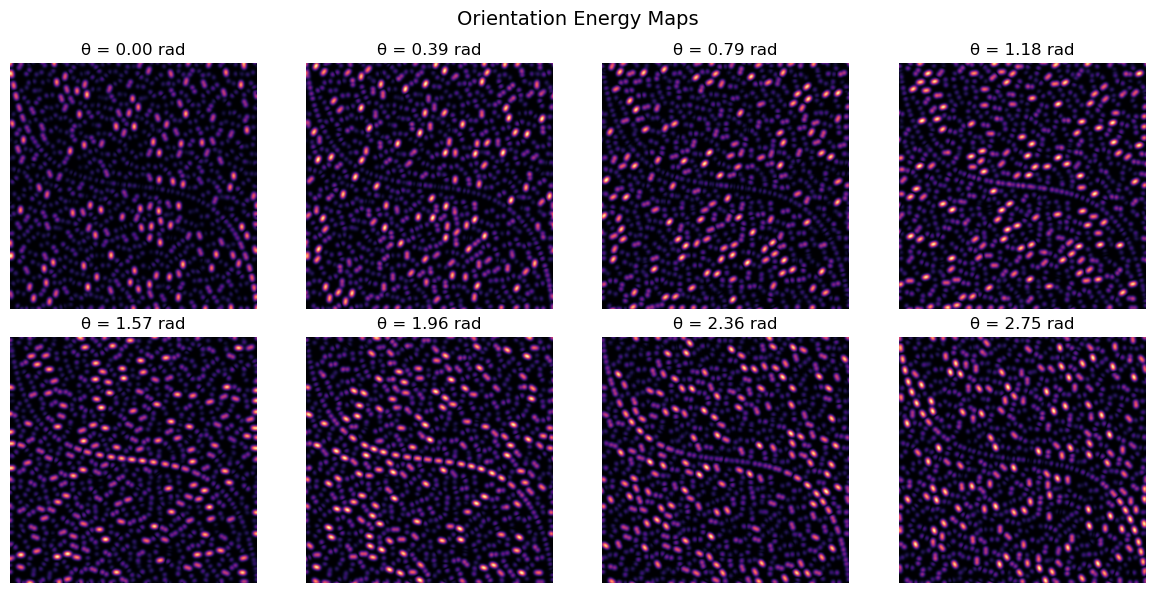

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gabor
from skimage import exposure


def compute_orientation_energy(If, orientations=None, frequency=0.1):
    """
    Compute orientation energy maps using Gabor filters.

    Parameters
    ----------
    If : np.ndarray
        2D grayscale image.
    orientations : list or np.ndarray
        List of orientations (radians) for Gabor filters.
    frequency : float
        Gabor filter frequency (default=0.1).

    Returns
    -------
    energy_maps : np.ndarray
        3D array of shape (H, W, num_orientations)
    orientations : np.ndarray
        Array of orientation angles used.
    """
    if orientations is None:
        orientations = np.linspace(0, np.pi, 8, endpoint=False)

    energy_maps = []
    for theta in orientations:
        real, imag = gabor(If, frequency=frequency, theta=theta)
        energy = np.sqrt(real**2 + imag**2)
        energy_maps.append(energy)

    return np.stack(energy_maps, axis=-1), orientations


def plot_orientation_energy_maps(energy_maps, orientations, cmap="magma"):
    """
    Plot orientation energy maps.

    Parameters
    ----------
    energy_maps : np.ndarray
        3D array of shape (H, W, num_orientations)
    orientations : np.ndarray
        Array of orientation angles (radians)
    cmap : str
        Colormap for visualization.
    """
    n = len(orientations)
    fig, axes = plt.subplots(2, n // 2, figsize=(12, 6))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        energy_img = exposure.rescale_intensity(energy_maps[..., i])
        ax.imshow(energy_img, cmap=cmap)
        ax.set_title(f"θ = {orientations[i]:.2f} rad")
        ax.axis("off")

    plt.suptitle("Orientation Energy Maps", fontsize=14)
    plt.tight_layout()
    plt.show()

# Normalize the image
If = Im.astype(float)
If = (If - If.min()) / (If.max() - If.min() + 1e-8)

energy_maps, orientations = compute_orientation_energy(If, frequency=0.15)
plot_orientation_energy_maps(energy_maps, orientations)

### Add jitters

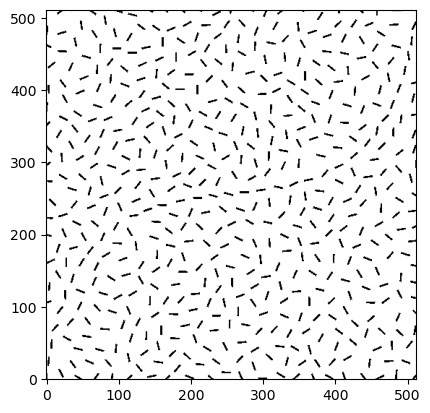

In [ ]:
# H1 = H + np.random.randn(*H.shape) * 0.25
H1 = gs.utils.add_jitter(H[:,0], H[:,1], 30).T

If = gs.patch.generate_image(C, H1, N=N, pfunc=pfunc)

I = If + Ig

Im = I.copy()
# Im = np.fliplr(np.rot90(Im,-1))

plt.imshow(Im, aspect='equal', origin='lower', cmap='binary')
# plt.set_cmap('binary')

### Same generation but with Gabor patches

In [ ]:
f = 100
σ2 = 0.002
pfunc = lambda z,h: gs.patch.gabor(z, h, f, σ2)

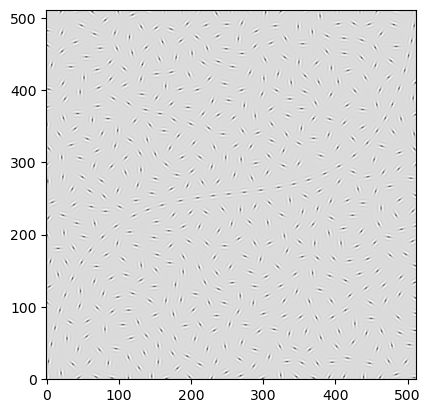

In [ ]:
N = 512
If = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig = gs.patch.generate_image(D, N=N, pfunc=pfunc)
I = If + Ig

plt.imshow(I, aspect='equal', origin='lower', cmap='Greys')

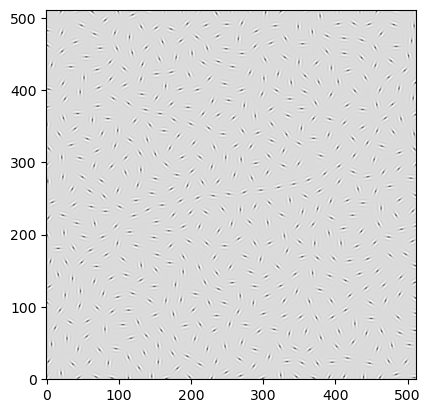

In [ ]:
# H1 = H + np.random.randn(*H.shape) * 0.25
H1 = gs.utils.add_jitter(H[:,0], H[:,1], 30).T

If = gs.patch.generate_image(C, H1, N=N, pfunc=pfunc)
I = If + Ig

plt.imshow(I, aspect='equal', origin='lower', cmap='Greys')


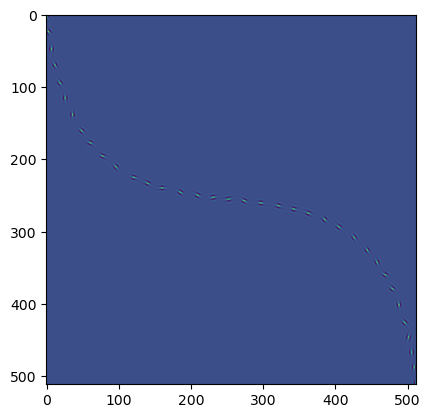

In [ ]:
plt.imshow(If)

# EOF